In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import xgboost as xgb

from scipy import sparse
from IPython.display import Image
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

sns.set(style="ticks", color_codes=True)
%matplotlib inline

import os
import json

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from datetime import datetime
import dateutil

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
Path = "profiles/"
filelist = os.listdir(Path)

In [3]:
def read_all():
    
    flag=0
    flag2=0
    
    user_keys = ['alias', 'username', 'numberPosts', 'descriptionProfile', 'numberFollowers', 'numberFollowing', 'urlProfile', 'urlImgProfile', 'website'] # The keys you want
    post_keys = ['url', 'urlImage', 'numberLikes', 'localization', 'date', 'description', 'tags', 'multipleImage', 'mentions', 'isVideo', 'filename'] # The keys you want
    
    #user_cols=['urlProfile', 'numberPosts', 'alias', 'descriptionProfile',  'numberFollowers', 'urlImgProfile', 'username', 'website', 'numberFollowing']
    user_cols=['urlProfile', 'alias', 'numberFollowing', 'numberFollowers', 'username', 'numberPosts', 'website', 'descriptionProfile',  'urlImgProfile']
    # might switch multipleImage and isVideo
    post_cols = ['url', 'description',  'date', 'numberLikes', 'tags', 'filename', 'urlImage', 'localization', 'isVideo', 'multipleImage', 'mentions']
    
    for k in filelist:
        if k.endswith(".json"):  # You could also add "and i.startswith('f')
            
            # Read file
            with open(Path + str(k)) as json_data:
                        data = json.load(json_data)
                            
            if (data['posts']!=[]):
                
                if data["descriptionProfile"]!=None:
                    temp=data["descriptionProfile"]
                    data["descriptionProfile"]=temp[0]
                           
                # Generate user data
                user_data=dict((k, data[k]) for k in user_keys if k in data)
                user_df=pd.DataFrame.from_dict(user_data, orient='index').T

                # Generate posts data for given user
                for i in range(0,len(data['posts'])):
                    
                    for k in post_keys:
                        if k in data['posts'][i]:
                            if isinstance(data['posts'][i][k], str):
                                data['posts'][i][k]=data['posts'][i][k].replace('\r','')

                    post=dict((k, data['posts'][i][k]) for k in post_keys if k in data['posts'][i])

                    if (flag==0):
                        all_posts=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        flag=1
                    else:
                        new_post=np.hstack((user_df, pd.DataFrame.from_dict(post, orient='index').T))
                        all_posts=np.vstack((all_posts,new_post)) 


                if (flag2==0):
                    total=pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))
                    flag2=1
                else:
                    total=np.vstack((total,pd.DataFrame(all_posts, columns=list(reversed(user_keys))+list(reversed(post_keys)))))   
           
                flag=0

    dataset=pd.DataFrame(total, columns=user_cols+post_cols)
    return dataset[["alias", "username", "numberFollowers", "numberFollowing", "numberPosts", 'urlProfile', 'urlImgProfile', 'descriptionProfile', 'website', 'filename', 'url', 'urlImage', 'numberLikes', 'description', 'tags', 'mentions', 'localization', 'date', 'multipleImage', 'isVideo']]

In [ ]:
dataset = read_all()
dataset.to_csv('newDataset.csv', index=False)

# Import Dataset

In [75]:
full=pd.read_csv('dataset.csv', sep=',', na_values='NaN')

# Drop corrupted images
full = full[full['urlImage'] != 'https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18161692_170571873469417_6901717925879611392_n.jpg']
full = full[full['urlImage'] != 'https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18251971_1131644876964262_6190143287764975616_n.jpg']

y=full["numberLikes"]



toDrop = ['username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
processed = full.drop(toDrop,axis=1)

nonCat = ['descriptionProfile', 'description', 'tags', 'mentions', 'localization']
processed = processed.drop(nonCat, axis=1)

# NLP

In [76]:
nlp = pd.read_csv('NLP_feature.csv', sep=',', na_values='NaN')
#nlp = nlp.drop(["Unnamed: 0"],axis=1)

# NN Joseph

In [77]:
nn_train = pd.read_csv('train_ll.csv', sep=',', na_values='NaN')
nn_train.columns = ['0_', '1_', '2_', '3_', '4_', '5_', '6_', '7_']
nn_test = pd.read_csv('test_ll.csv', sep=',', na_values='NaN')
nn_test.columns = ['0_', '1_', '2_', '3_', '4_', '5_', '6_', '7_']


# Select data

In [6]:
pd.options.display.float_format = '{:.2f}'.format
processed.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes
count,16537.00,16537.00,16537.00,16537.00
mean,2315.91,2590.88,997926.14,24416.38
std,2655.50,59094.23,1934497.75,64224.20
min,15.00,0.00,124965.00,0.00
25%,787.00,191.00,198039.00,3232.00
50%,1481.00,396.00,393843.00,7351.00
75%,2932.00,645.00,935310.00,18359.00
max,27671.00,1838511.00,22130730.00,1115123.00


(array([  1.54140000e+04,   6.13000000e+02,   2.34000000e+02,
          9.10000000e+01,   6.60000000e+01,   4.00000000e+01,
          2.30000000e+01,   1.50000000e+01,   5.00000000e+00,
          1.10000000e+01,   8.00000000e+00,   5.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   3.00000000e+00]),
 array([       0.        ,    74341.53333333,   148683.06666667,
          223024.6       ,   297366.13333333,   371707.66666667,
          446049.2       ,   520390.73333333,   594732.26666667,
          669073.8       ,   743415.33333333,   817756.86666667,
          892098.4       ,   966439.93333333,  1040781.46666667,  1115123.        ]),
 <a list of 15 Patch objects>)

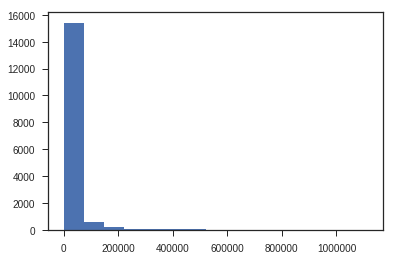

In [7]:
plt.hist(processed.numberLikes, 15)
#plt.xlim(80000, 800000)
#plt.ylim(0, 2000)

(array([ 14242.,   1190.,    374.,    255.,    153.,     68.,    119.,
            34.,     17.,     17.,     17.,     17.,      0.,     17.,
            17.]),
 array([   124965.,   1592016.,   3059067.,   4526118.,   5993169.,
          7460220.,   8927271.,  10394322.,  11861373.,  13328424.,
         14795475.,  16262526.,  17729577.,  19196628.,  20663679.,
         22130730.]),
 <a list of 15 Patch objects>)

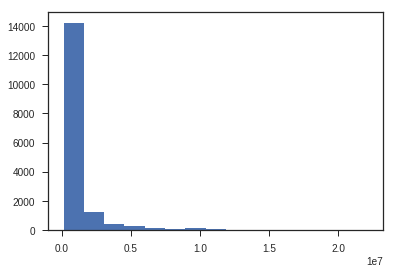

In [8]:
plt.hist(processed.numberFollowers, 15)

In [78]:
le = preprocessing.LabelEncoder()
le.fit(processed["alias"])
list(le.classes_)
alias_num=le.transform(processed["alias"])
#list(le.inverse_transform(alias_num))
processed["aliasNum"]=alias_num

In [11]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"],axis=0)):
    numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(processed[processed["aliasNum"]==i]["numberLikes"])/len(processed[processed["aliasNum"]==i]))
    processed.loc[processed["aliasNum"]==i, 'ratio']=avgLikes[i]
    if (avgLikes[i]<200000 and processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000):
        selection=np.append(selection, i)

In [12]:
pd.DataFrame(selection).describe()

,0
count,746.00
mean,479.87
std,281.85
min,0.00
25%,239.25
50%,477.50
75%,725.50
max,971.00


In [13]:
po=pd.DataFrame(avgLikes/numFollowers)
po.describe()

,0
count,972.00
mean,0.02
std,0.02
min,0.00
25%,0.01
50%,0.02
75%,0.03
max,0.17


In [80]:
processed = pd.concat([processed, nlp], axis=1)

In [81]:
processed

,numberPosts,website,numberFollowing,alias,numberFollowers,date,multipleImage,numberLikes,aliasNum,able,...,27,28,29,30,31,32,33,34,35,36
0,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-29T05:00:00.000Z,False,10047.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-29T05:00:00.000Z,False,16781.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-27T05:00:00.000Z,False,11227.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-24T05:00:00.000Z,False,21539.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-22T05:00:00.000Z,False,21054.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-22T05:00:00.000Z,False,12375.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-21T05:00:00.000Z,False,15335.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-21T05:00:00.000Z,False,29161.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-21T05:00:00.000Z,False,10267.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
9,988.00,www.sylviemeis.de,233.00,1misssmeis,720979.00,2017-04-20T05:00:00.000Z,False,29776.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [15]:
filtered=processed[processed['aliasNum'].isin(selection)]
filtered.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes,aliasNum,ratio,able,account,actually,ad,...,27,28,29,30,31,32,33,34,35,36
count,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,...,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00
mean,1941.19,3026.96,362541.21,8306.93,479.79,8306.93,0.01,0.01,0.01,0.02,...,0.02,0.02,0.02,0.01,0.03,0.02,0.02,0.04,0.04,0.01
std,2007.75,67264.20,227129.31,9999.27,281.65,9335.99,0.08,0.09,0.08,0.12,...,0.14,0.22,0.18,0.14,0.21,0.43,0.13,0.28,0.28,0.14
min,15.00,0.00,124965.00,0.00,0.00,110.87,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,722.00,202.00,180286.00,2630.00,239.00,2882.18,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1369.00,405.50,283490.00,5296.00,477.00,5447.65,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2566.00,656.00,493550.00,10323.75,726.00,10379.94,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,19590.00,1838511.00,996578.00,180164.00,971.00,120681.47,2.00,2.00,2.00,3.00,...,4.00,9.00,9.00,6.00,7.00,18.00,3.00,3.00,2.00,5.00


(0, 200000)

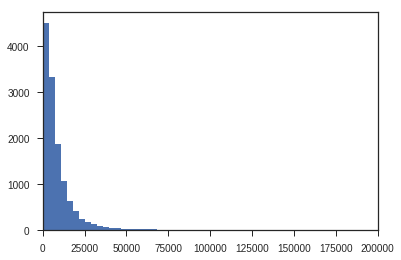

In [16]:
plt.hist(filtered.numberLikes, 50)
plt.xlim(0, 200000)
#plt.ylim(0, 2000)

(0, 1000000)

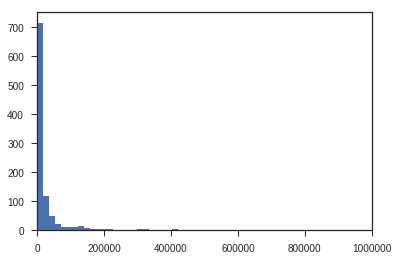

In [17]:
plt.hist(avgLikes,50)
plt.xlim(0, 1000000)
#plt.ylim(0, 2000)

In [18]:
pd.DataFrame(avgLikes).describe()

,0
count,972.00
mean,24429.84
std,61732.58
min,110.87
25%,3594.37
50%,7689.24
75%,18719.16
max,875806.41


# Feature extraction

In [82]:
modified = filtered.drop(["alias"],axis=1)
modified = modified.reset_index(drop=True)

### Convert website to categorical features

In [83]:
modified['you']=modified['website'].str.contains("youtube|youtu", na=False).astype(int)
modified['music']=modified['website'].str.contains("soundcloud|spoti", na=False).astype(int)
modified['tumblr']=modified['website'].str.contains("tumblr", na=False).astype(int)
modified['facebook']=modified['website'].str.contains("facebook", na=False).astype(int)
modified['blog']=modified['website'].str.contains("blog|wordpress", na=False).astype(int)
modified['twitter']=modified['website'].str.contains("twitter", na=False).astype(int)
modified['other']=modified['website'].str.contains(".", na=False).astype(int)

modified = modified.drop(['website'], axis=1)

### Convert multipleImage to int

In [84]:
modified['multipleImage']=modified['multipleImage'].astype(int)

### Convert dates to days of week

In [85]:
copy=modified["date"].copy()
for i in range(0, len(modified)):
    copy[i] = datetime.weekday((dateutil.parser.parse(modified["date"][i])))
modified["date"]=copy.astype(np.int64)

modified['mon']=(modified['date']==0).astype(int)
modified['tue']=(modified['date']==1).astype(int)
modified['wed']=(modified['date']==2).astype(int)
modified['thu']=(modified['date']==3).astype(int)
modified['fri']=(modified['date']==4).astype(int)
modified['sat']=(modified['date']==5).astype(int)
modified['sun']=(modified['date']==6).astype(int)

modified = modified.drop(['date'], axis=1)

### One hot encode alias number

In [123]:
# One hot encoding
encoder = OneHotEncoder()
encoder.fit(modified["aliasNum"].values.reshape(-1, 1))
alias_sparse = encoder.transform(modified["aliasNum"].values.reshape(-1, 1))

In [23]:
y = modified['numberLikes']
modified = modified.drop(['numberLikes'],axis=1)

In [146]:
modified=sp.sparse.hstack((modified.astype(float), alias_sparse))

In [55]:
modified.describe()

,numberPosts,numberFollowing,numberFollowers,multipleImage,numberLikes,aliasNum,ratio,able,account,actually,...,tumblr,facebook,twitter,other,mon,tue,wed,thu,fri,sat
count,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,...,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00,12678.00
mean,1941.19,3026.96,362541.21,0.03,8306.93,479.79,8306.93,0.01,0.01,0.01,...,0.00,0.04,0.00,0.88,0.11,0.13,0.14,0.15,0.14,0.15
std,2007.75,67264.20,227129.31,0.17,9999.27,281.65,9335.99,0.08,0.09,0.08,...,0.04,0.21,0.05,0.32,0.32,0.34,0.35,0.36,0.35,0.35
min,15.00,0.00,124965.00,0.00,0.00,0.00,110.87,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,722.00,202.00,180286.00,0.00,2630.00,239.00,2882.18,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1369.00,405.50,283490.00,0.00,5296.00,477.00,5447.65,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2566.00,656.00,493550.00,0.00,10323.75,726.00,10379.94,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
max,19590.00,1838511.00,996578.00,1.00,180164.00,971.00,120681.47,2.00,2.00,2.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


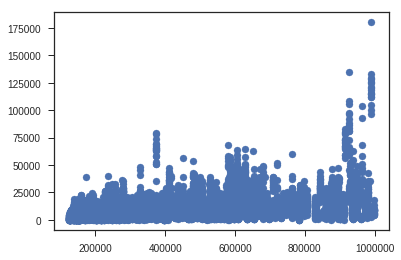

In [23]:
plt.scatter(modified["numberFollowers"], modified["numberLikes"])

# Create train and test dataset

In [99]:
deleted=modified[modified["aliasNum"].astype(int)==0][0:2]
test=modified[modified["aliasNum"].astype(int)==0][3:6]
train=modified[modified["aliasNum"].astype(int)==0][6:len(modified[modified["aliasNum"].astype(int)==0])]

for i in range(1,np.max(modified["aliasNum"].astype(int),axis=0)):
#for i in range(0,10):
    deleted = pd.concat([deleted, modified[modified["aliasNum"]==i][0:2]], axis=0)
    test = pd.concat([test, modified[modified["aliasNum"]==i][3:6]], axis=0)
    train = pd.concat([train, modified[modified["aliasNum"]==i][6:len(modified[modified["aliasNum"]==i])]], axis=0)

In [100]:
X_train = train.drop(['numberLikes'],axis=1)
y_train = train['numberLikes']
X_test = test.drop(['numberLikes'],axis=1)
y_test = test['numberLikes']

In [87]:
X_train = pd.concat([X_train, nn_train], axis=1)

In [88]:
X_test = pd.concat([X_test, nn_test], axis=1)

In [107]:
X_train=pd.read_csv('train.csv', sep=',', na_values='NaN')
y_train = X_train['numberLikes']
X_train = X_train.drop(['numberLikes'],axis=1)

X_test=pd.read_csv('test.csv', sep=',', na_values='NaN')
y_test = X_test['numberLikes']
X_test = X_test.drop(['numberLikes'],axis=1)

In [109]:
toDrop = ['username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
X_train = X_train.drop(toDrop,axis=1)

nonCat = ['descriptionProfile', 'description', 'tags', 'mentions', 'localization']
X_tesst = X_test.drop(nonCat, axis=1)

In [111]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train = pd.concat([X_train, nn_train], axis=1)
X_test = pd.concat([X_test, nn_test], axis=1)

In [122]:
X_train.shape

(10690, 21)

In [23]:
y = modified['numberLikes']
modified = modified.drop(['numberLikes'],axis=1)

In [24]:
modified.describe()

,numberPosts,numberFollowing,numberFollowers,multipleImage,aliasNum,ratio,able,account,actually,ad,...,tumblr,facebook,twitter,other,mon,tue,wed,thu,fri,sat
count,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,...,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00
mean,1941.02,3026.48,362515.26,0.03,479.80,8306.70,0.01,0.01,0.01,0.02,...,0.00,0.04,0.00,0.88,0.11,0.13,0.14,0.15,0.14,0.15
std,2007.64,67258.90,227120.79,0.17,281.63,9335.25,0.08,0.09,0.08,0.12,...,0.04,0.21,0.05,0.32,0.32,0.34,0.35,0.36,0.35,0.35
min,15.00,0.00,124965.00,0.00,0.00,110.87,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,722.00,202.00,180286.00,0.00,239.00,2882.18,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1369.00,405.00,283490.00,0.00,477.00,5448.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2566.00,656.00,493550.00,0.00,726.00,10379.94,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
max,19590.00,1838511.00,996578.00,1.00,971.00,120681.47,2.00,2.00,2.00,3.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Split train and test dataset

In [161]:
X_train, X_test, y_train, y_test = train_test_split(modified, y, test_size=0.2, random_state=0)

In [97]:
X_test.shape

(2916, 563)

In [98]:
y_test.shape

(2235,)

# XGB

In [118]:
model_xgb = xgb.XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=596)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields website, descriptionProfile, alias, date, mentions, localization, tags, description

In [31]:
model_xgb.score(X_test,y_test)

0.8643826060030394

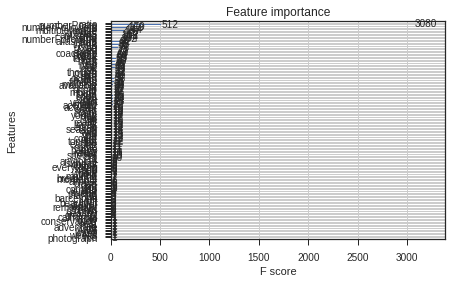

In [32]:
xgb.plot_importance(model_xgb, importance_type='weight') # weight, gain or cover

In [33]:
vec = model_xgb.feature_importances_

In [34]:
vec

array([  6.90212995e-02,   1.37503371e-02,   2.41304934e-02,
         1.94122400e-02,   1.30763007e-02,   4.15206254e-01,
         0.00000000e+00,   2.96575902e-03,   2.69614463e-03,
         0.00000000e+00,   5.39228925e-03,   0.00000000e+00,
         1.34807226e-04,   0.00000000e+00,   2.29172292e-03,
         1.88730122e-03,   0.00000000e+00,   8.08843353e-04,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.50984097e-02,   1.41547583e-02,
         0.00000000e+00,   0.00000000e+00,   1.21326500e-03,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.77460243e-03,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         8.08843318e-03,   4.04421677e-04,   0.00000000e+00,
         4.04421677e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.34807226e-04,   0.00000000e+00,
         8.08843353e-04,

In [35]:
for i in range(len(vec)):
    if vec[i] > 0.01:
        print(i)

0
1
2
3
4
5
22
23
179
182
265
269
367
423
432
516
524


### True vs pred

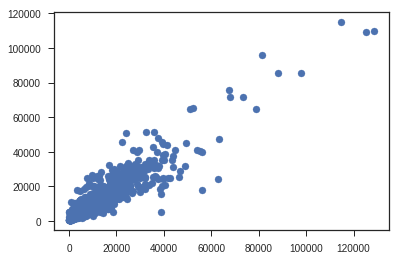

In [36]:
plt.scatter(y_test, y_pred)
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

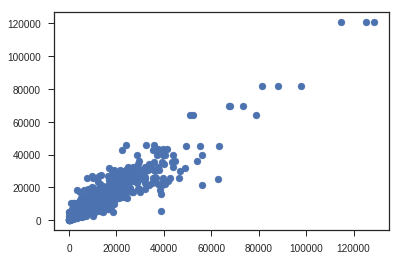

In [37]:
plt.scatter(y_test, X_test['ratio'])
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

In [38]:
RMSE = mean_squared_error(y_test, X_test['ratio'])**0.5
print(RMSE)

3509.05879138


### Test vs residuals

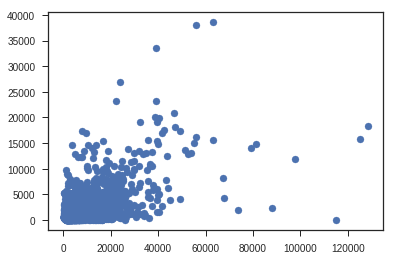

In [39]:
plt.scatter(y_test, abs(y_pred-y_test))

In [40]:
true = pd.DataFrame(y_test)
pred = pd.DataFrame(y_pred)

In [41]:
true = true.reset_index(drop=True)

In [42]:
true[(true<10000).values].index

Int64Index([   3,    4,    6,    7,    8,    9,   10,   11,   15,   16,
            ...
            2223, 2224, 2225, 2226, 2227, 2228, 2231, 2232, 2233, 2234],
           dtype='int64', length=1651)

In [43]:
subTrue = true[(true<10000).values]

In [44]:
subPred = pred.ix[true[(true<10000).values].index]

(0, 20000)

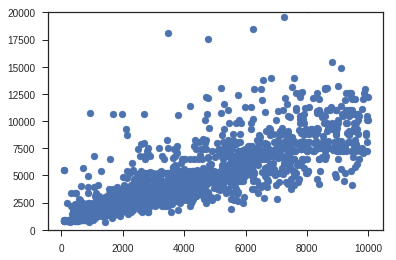

In [46]:
plt.scatter(subTrue,subPred)
plt.ylim(0, 20000)

In [162]:
def score(params):
    global best2
    global count
    count=count+1
    print(count)
    num_round = int(params['n_estimators'])
    del(params['n_estimators'])
    #params['n_estimators']=num_round
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = mean_squared_error(y_test, predictions)**0.5
    
    if (score<best2):
        best2=score
        print(params)
        print(num_round)
        print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [165]:
def optimize():
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('learning_rate', 0.01, 0.2, 0.01),
             'max_depth' : hp.choice('max_depth', np.arange(3, 4, dtype=int)),
             #'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
            #'subsample' : hp.quniform('subsample', 0.6, 0.9, 0.05),
            # 'gamma' : hp.quniform('gamma', 0.6, 0.8, 0.05),
            #'colsample_bytree' : hp.quniform('colsample_bytree', 0.7, 1, 0.05),
              #'reg_alpha' : hp.quniform('reg_alpha', 0.001, 10, 0.01),
             #'reg_lambda' : hp.quniform('reg_lambda', 0.001, 10, 0.01),
             }

    best = fmin(score, space, algo=tpe.suggest, max_evals=50)

    print(best)

In [166]:
best2=100000
count=0
optimize()

1
{'max_depth': 3, 'learning_rate': 0.15}
257
	Score 3667.8827755100597


2
3
4
{'max_depth': 3, 'learning_rate': 0.01}
518
	Score 3631.2273271904


5
6
7
8
9
{'max_depth': 3, 'learning_rate': 0.13}
108
	Score 3623.3584956195396


10
11
12
13
14
15
16
17
18
19
{'max_depth': 3, 'learning_rate': 0.1}
138
	Score 3620.447529798547


20
21
{'max_depth': 3, 'learning_rate': 0.09}
123
	Score 3615.5997506414537


22
{'max_depth': 3, 'learning_rate': 0.09}
159
	Score 3610.8324738235074


23
24
25
26
27
28
29
30
31
32
33
34


KeyboardInterrupt: 

# Presentation

### 1. Only the number of followers/posts

### 2. Add the avgLikes of a user

In [ ]:
#### 3. 